## Submission

### Simple Neural Net:
1. Code provided in the the assignment
2. Repopulating Functions to evolve a better population, these include:
    - Tournament selection
    - Elitism
    - Rank order selection
    - Proportional selection
    - Recombination
3. Fitness Functions:
    - measure_proportional_distance_to_light
    - measure_displacement
    - measure_distance
    - measure_distance_to_light
4. Run function
    - Run to evolve population
5. Simple Neural Net Population

### Advanced Extensions:
1. NEAT
    - Description for NEAT
    - Fitness Functions:
        - Similar to the ones in Neural Net, except modified to be neat(heh)
    - Sample Run
    - Evolved Population

### First, importing code to setup world as given in the assignment

In [13]:
from IPython.display import display, clear_output
from jyro.simulator import *
import random
import numpy as np
import pickle

#Here is the main difference, I'm just random generating some walls
#either on the left or right side of the world, evenly spaced along 
#the length of the world. 
def add_walls(sim, num_walls):
    pos_xs = np.linspace(1.5, 10, num_walls)

    for i in range(num_walls):
        width = random.uniform(0.1, 0.3)
        pos_y1 = random.choice([12-0.25, 0.25])
        length = random.uniform(3, 10)
        sim.addBox(pos_y1, pos_xs[i], length, pos_xs[i]+width, fill="gray", wallcolor="gray")

# We'll create a box for the robot to live in
# and a light source
def make_world(sim):
    sim.addBox(0, 0, 12, 12, fill="backgroundgreen", wallcolor="gray") #bounding box
    sim.addLight(11, 11, 1) #paramters are x, y, brightness
    add_walls(sim, 6)
    
#We'll give our robot the 16 sonar distance sensors, some light sensors
class MyPioneer(Pioneer):
    def __init__(self, name, x, y, angle):
        Pioneer.__init__(self, name, x, y, angle)
        self.addDevice(Pioneer16Sonars())
        #parameter defines max range in meters
        self.addDevice(PioneerFrontLightSensors(3))
        
    def move(self, linear, rotational):
        if -1 > linear > 1 or -1 > rotational > 1:
            super().move(random.uniform(-1, 1), random.uniform(-1, 1))
            print("moving randomly!")
        else:
            super().move(linear, rotational)
        


def setup_world(robot_brain):
    robot = MyPioneer("Johnny", 1, 1, 0)
    sim = Physics()
    make_world(sim)
    sim.addRobot(robot)
    robot.brain = robot_brain
    return sim, robot

### Neural Network code for the robot

TODO: *Extension:* Add Position as another input to the brain.

In [14]:
class SimpleNeuralNet():
    #This is our squashing function
    #I changed this to the hyperbolic tangent function that
    #returns values in (-1, 1)
    def activation_function(self, x):
        return np.tanh(x)
    
    #this should look familiar, just a way to create a copy of 
    #the network without worying about pesky reference 
    def deepcopy(self):
        new_net = SimpleNeuralNet(self.num_inputs, self.num_outputs, self.layer_node_counts)
        new_net.layers = [np.copy(layer) for layer in self.layers]
        return new_net
    
    #this is where the neural network does its computation!
    def execute(self, input_vector):
        # First we need to make sure we're getting the right
        # number of inputs into our neural network.
        assert len(input_vector) == self.num_inputs ,\
        "wrong input vector size"

        # create a temporary variable to hold the values that should go
        # into the next layer of the network.
        # **at the start, this will just be our input**
        next_v = input_vector

        # iterate through layers, computing the activation
        # of the weighted inputs from the previous layer
        for layer in self.layers:
            # add a bias to each layer [1]
            next_v = np.append(next_v, 1)
            
            # pump the input vector through the matrix multiplication
            # and our activation function
            next_v = self.activation_function(np.dot(next_v, layer))
            
        return next_v
        
    def __init__(self, num_inputs, num_outputs, layer_node_counts=[]):
        self.num_inputs = num_inputs
        self.layer_node_counts = layer_node_counts
        self.num_outputs = num_outputs
        self.layers = []
        
        last_num_neurons = self.num_inputs
        for nc in layer_node_counts + [num_outputs]:
            # for now, we'll just use random weights in the range [-5,5]
            # +1 handles adding a bias node for each layer of nodes
            self.layers.append(np.random.uniform(-5, 5, size=(last_num_neurons+1, nc)))
            last_num_neurons = nc

In [15]:
def network_to_brain(simple_net):
    
    #Define the brain function for jyro
    def neural_brain(a_robot):
        sonar_sensors = a_robot["sonar"].getData()
        light_sensors = a_robot["light"].getData()
        
        #combine the sonar and light inputs
        combined_input = sonar_sensors + light_sensors

        network = simple_net

        #run the neural network with the combined input values
        output = network.execute(combined_input)
        
        #use the output of the network to move the robot
        a_robot.move(output[0], output[1])

    return neural_brain

def mutate_network(simple_net, mutation_rate=1E-3, mutation_effect_size=2):
    for layer_to_mut in simple_net.layers:
        dims = layer_to_mut.shape
        num_mutations = np.random.binomial(dims[0]*dims[1], mutation_rate)
        for i in range(num_mutations): 
            rand_i = np.random.randint(0, dims[0])
            rand_j = np.random.randint(0, dims[1])
            layer_to_mut[rand_i, rand_j] += np.random.normal(scale=mutation_effect_size)

### Repopulating Functions
#### *Extensions*: 
- **Tournament selection** now returns a whole population
- **Elitism** selects for the best *n* brains and repopulates using those
- **Rank order selection** selects based on the rank-order formula, with k uniformally from 0.1 - 1
- **Proportional** selects based on the proportional fitness
- **Recombination** selects n/k fittest from the population and recombines their brain to form 2k/3 new robots

In [16]:
def tournament_selection(population, fitnesses, tournament_size=3):
    new_pop = []
    for _ in range(len(population)):
        sample_pop_idxs = np.random.choice(range(len(population)), size=tournament_size)
        tourny_winner_idx = np.argmax(np.array(fitnesses)[sample_pop_idxs])
        winner_pop_idx = sample_pop_idxs[tourny_winner_idx]
        new_pop.append(population[winner_pop_idx])
    return new_pop

In [17]:
def rank_order_selection(population, fitnesses, factor=0.1):
    factor = np.uniform(0.1, 1)
    combined_pop = zip(population, fitnesses)
    population = [x for _,x in sorted(zip(fitnesses, population), reverse=True)]
    scaled_fitness = [(factor**float(len(population)-g))*(factor-1)/(factor**float(len(population))-1) for g in range(len(population))]
    population = random.choices(population, k=len(population), weights=scaled_fitness)
    return population

In [18]:
def elitism(population, fitnesses, factor = 7):
    combined_pop = zip(population, fitnesses)
    # Sort based on fitness
    population = [x for _,x in sorted(zip(fitnesses, population), reverse=True, key=lambda pair: pair[0])]
    fitnesses = sorted(fitnesses, reverse=True)
    len_pop = len(population)
    # Mark the first 'factor' as eiltes
    elites = population[:factor]
    elites_fitness = fitnesses[:factor]
    new_elites = []
    # create new_elites using elites
    for net in range(len_pop - factor):
        new_elite = random.choices(elites, k=1, weights=elites_fitness)[0]
        new_elites.append(new_elite)
        mutate_network(new_elite, mutation_rate=0.50)
    # Add new_elites to elites and return
    elites.extend(new_elites)
    population = elites
    return population

In [19]:
def proportional(population, fitnesses, factor = 1):
    population = random.choices(population, k=len(population), weights=np.dot(fitnesses,factor))
    return population

In [20]:
def combine_2(robot_1, robot_2):
    layer_1 = robot_1.layers.deepcopy()
    layer_2 = robot_2.layers.deepcopy()
    len_layer = len(layer_1)
    new_layer = layer_1[:(len_layer/2)]
    new_layer.extend(layer_2[len_layer:])
    new_robot = SimpleNeuralNet(18,2,[10])
    new_robot.layers = new_layer
    return new_robot
    
def recombination(population, fitnesses, factor = 5):
    combined_pop = zip(population, fitnesses)
    # Sort based on fitness
    population = [x for _,x in sorted(zip(fitnesses, population), reverse=True, key=lambda pair: pair[0])]
    fitnesses = sorted(fitnesses, reverse=True)
    elites = population[:factor]
    elites_fitness = fitnesses[:factor]
    new_elites = []
    # recombine using num(factor) elites
    for net in range(len_pop - factor):
        recombine_1, recombine_2 = random.choices(elites, k=2, weights=elites_fitness, replace = True)
        new_elite = combine_2(robot_1, robot_2)
        new_elites.append(new_elite)
        mutate_network(new_elite, mutation_rate=0.1)
    # Add new_elites to elites and return
    elites.extend(new_elites)
    population = elites
    return population

### Fitness Functions
#### *Extensions*: 
- **measure_proportional_distance_to_light** measures the total distance travelled towards the light over the displacement.
- **measure_displacement** measures the displacement
- **measure_distance**, was given and measures the total distance a robot has travelled
- **measure_distance_to_light** measures the absolute distance to the light

In [21]:
def measure_proportional_distance_to_light(simple_net, iterations=250):
    this_brain = network_to_brain(simple_net)
    sim, robot = setup_world(this_brain)
    
    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    sonar = [11, 11]
    y_2 = robot.getPose()
    y_1 = robot.getPose()
    start = math.hypot(y_2[0]-sonar[0], y_2[1] - sonar[1])
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!   
        if robot.stall:
            break
        #move the robot
        sim.step(run_brain=True)
    y_2 = robot.getPose()
    total_distance = math.hypot(y_2[0]-y_1[0], y_2[1] - y_1[1])
    end = math.hypot(y_2[0]-sonar[0], y_2[1] - sonar[1])
    return (start - end)/total_distance

In [22]:
def measure_displacement(simple_net, iterations=500):
    this_brain = network_to_brain(simple_net)
    sim, robot = setup_world(this_brain)

    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    x = robot.getPose()
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!   
        if robot.stall:
            break
        #move the robot
        sim.step(run_brain=True)
    y = robot.getPose()
    total_distance = math.hypot(y[0]-x[0], y[1] - x[1])
    return total_distance

In [23]:
def measure_distance(simple_net, iterations=500):
    this_brain = network_to_brain(simple_net)
    sim, robot = setup_world(this_brain)

    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    x = robot.getPose()
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!   
        if robot.stall:
            break
        #move the robot
        cur_pos = robot.getPose()
        sim.step(run_brain=True)
        next_pos = robot.getPose()
        
        #and keep track of how far it moved
        distance_moved += np.linalg.norm(np.array(cur_pos[0:2]) - np.array(next_pos[0:2]))
    return distance_moved

In [24]:
def measure_distance_to_light(simple_net, iterations=500):
    this_brain = network_to_brain(simple_net)
    sim, robot = setup_world(this_brain)
    
    distance_moved = 0
    
    #reset the robot's position
    robot.setPose(1, 1, 0)
    robot.reset()
    sonar = [11, 11]
    #iterate through the simulation
    for i in range(iterations):        
        #but if the robot's stuck, end early!   
        if robot.stall:
            break
        #move the robot
        sim.step(run_brain=True)
    end = robot.getPose()
    distance_to_light = math.hypot(sonar[0]-end[0], sonar[1] - end[1])
    return 100/distance_to_light

In [ ]:
def save_simple_net(prefix, evolved_pop):
    for i, pop in enumerate(evolved_pop):
        pickle.dump(pop.deepcopy(), open(prefix + str(i) + '.pkl', 'wb'))
def return_simple_net(prefix, num):
    evolved = []
    for i in range(num):
        evolved.append(pickle.load(open(prefix + str(i) + '.pkl', 'rb')))
    return evolved
def delete_simple_net(prefix, num):
    for i in range(num):
        os.remove(prefix + str(i) + '.pkl')

### Run
run_evolution_with_fitness runs a given population of nets, num_generation times using a given fitness function to generate fitness and then using a given repopulating_func to generate a new population.

In [ ]:
def run_evolution(pop_size, num_generations):
    #build our random population of neural networks
    population = [SimpleNeuralNet(18,2,[10]) for _ in range(pop_size)]
    evo_fitnesses = []

    for i in range(num_generations):
        #evaluate the fitnesses using 50 timesteps
        fitnesses = [measure_displacement(n) for n in population]

        #keep track of the mean pop fitnesses
        evo_fitnesses.append(np.mean(fitnesses))

        #print the generation and the mean fitness we just stuck on the
        #evo_fitnesses list
        clear_output(wait=True)
        display(i, evo_fitnesses[-1])

        #do tournament selection
        next_pop = [x.deepcopy() for x in tournament_selection(population, fitnesses)]

        #and mutate the new networks
        for net in next_pop:
            mutate_network(net, mutation_rate=0.1)

        population = next_pop
    return population

In [15]:
def run_evolution_with_fitness(pop, num_generations, fitness_func, repopulating_func = tournament_selection):
    #build our random population of neural networks
    population = pop
    evo_fitnesses = []

    for i in range(num_generations):
        #evaluate the fitnesses using 50 timesteps
        fitnesses = [np.mean([fitness_func(n, iterations=500) for _ in range(10)]) for n in population]
        
        #keep track of the mean pop fitnesses
        evo_fitnesses.append(np.mean(fitnesses))

        #print the generation and the mean fitness we just stuck on the
        #evo_fitnesses list
        clear_output(wait=True)
        display(i, "mean:", evo_fitnesses[-1], "first:", fitnesses[0])

        #do tournament selection
        next_pop = [x.deepcopy() for x in repopulating_func(population, fitnesses, 3)]

        #and mutate the new networks
        for net in next_pop:
            mutate_network(net, mutation_rate=0.1)

        population = next_pop
    return population

In [ ]:
# Run with displacement
fittest = run_evolution(30, 20)
new_fittest = run_evolution_with_fitness(fittest, 25, measure_distance)
new_fittest = run_evolution_with_fitness(new_fittest, 25, measure_displacement)
new_fittest = run_evolution_with_fitness(new_fittest, 25, measure_distance_to_light)
new_fittest = run_evolution_with_fitness(new_fittest, 25, measure_proportional_distance_to_light)

In [ ]:
new_fittest_sorted = sorted(new_fittest, key = lambda x:(measure_displacement(x)), reverse = True)

In [ ]:
save_simple_net('submission', new_fittest_sorted)
# TO LOAD: return_simple_net('submission', 30)

In [ ]:
sim, robot = setup_world(network_to_brain(new_fittest[0]))
canvas = Canvas((250, 250))

for i in range(500):
    sim.step(run_brain=True)
    sim.draw(canvas)
    clear_output(wait=True)
    display(canvas)
    print(robot["light"].getData())
    time.sleep(0.01)
    if robot.stall:
        break

### NEAT
First, we import the neat library from the python, it can be installed with pip. 

Helper Functions:
1. get_brain_inputs: gets the input from the robot
2. setup_neat: creates the world, just like setup_world but returns the sim, with a *reference* to the robot object
3. setup_neat_static: creates a copy of a predefined global world(static_world) and returns the sim, and a reference to the robot object

The fitness functions take in the population, and then for each genome, create a FeedForwardNetwork which over each iteration in the simulation, accepts 18 inputs and outputs 2 values, which are then used to move the robot.

The Fitness functions:
1. avoid_wall_and_fly: Evolves the robot to travel the farthest it can in a predefined static world.
2. fitness_over_three: Evaluates the robot's fitness over 3 randomally generated canvases
3. binary_light_with_static_net: Evaluates the robot over a predefined static world and a random world. The fitness is rewarded as 100\*num_times it stays within 1 unit distance of the light.
4. binary_light: repeats the above function with a 3 random nets, for 200 steps.

In [39]:
import neat
import copy

In [30]:
def get_brain_inputs(a_robot):
    #Define the brain function for jyro
    sonar_sensors = a_robot["sonar"].getData()
    light_sensors = a_robot["light"].getData()

    #combine the sonar and light inputs
    combined_input = sonar_sensors + light_sensors
    return combined_input

def setup_neat():
    robot = MyPioneer("Johnny", 1, 1, 0)
    sim = Physics()
    make_world(sim)
    sim.addRobot(robot)
    return sim, robot

def setup_neat_static():
    global static_sim
    new_static = copy.deepcopy(static_sim)
    robot = MyPioneer("Johnny", 1, 1, 0)
    new_static.addRobot(robot)
    return new_static, robot

In [42]:
def avoid_wall_and_fly(nets, config, iterations=500):
    for genome_id, genome in nets:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        sim, robot = setup_neat_static()
        robot.setPose(1, 1, 0)
        moved = 0
        start = [1, 1]
        for i in range(250):
            if robot.stall:
                break
            inputs = get_brain_inputs(robot)
            x, y = net.activate(inputs[:])
            robot.move(x, y)
            sim.step()
        end = robot.getPose()
        moved = math.hypot(start[0] - end[0], start[1] - end[1])
        genome.fitness = moved

In [43]:
def fitness_over_three(nets, config, iterations=500):
    for genome_id, genome in nets:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        moved = 0
        for i in range(3):
            sim, robot = setup_neat()
            robot.setPose(1, 1, 0)
            moved = 0
            for i in range(100):
                if robot.stall:
                    break
                inputs = get_brain_inputs(robot)
                x, y = net.activate(inputs)
                robot.move(x, y)
                sim.step()
            end = robot.getPose()
            moved = moved+math.hypot(1-end[0], 1 - end[1])
        genome.fitness = moved/3

In [52]:
def binary_light_with_static_net(nets, config, iterations=150):
    for genome_id, genome in nets:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        light = [11, 11]
        moved_less_than_5 = 0
        sim, robot = setup_neat_static()
        robot.setPose(1, 1, 0)
        times_found = 0
        for i in range(200):
            inputs = get_brain_inputs(robot)
            x, y = net.activate(inputs)
            robot.move(x, y)
            sim.step()
            end = robot.getPose()
            dist_light = abs(math.hypot(light[0]-end[0], light[1] - end[1]))
            if dist_light < 8:
                times_found += (8-dist_light)
                break
            if robot.stall:
                break
        sim, robot = setup_neat()
        for i in range(200):
            inputs = get_brain_inputs(robot)
            x, y = net.activate(inputs)
            robot.move(x, y)
            sim.step()
            end = robot.getPose()
            dist_light = abs(math.hypot(light[0]-end[0], light[1] - end[1]))
            if dist_light < 2:
                times_found += (8-dist_light)
                break
            if robot.stall:
                break
        genome.fitness = 10*times_found

In [53]:
def binary_light(nets, config, iterations=150):
    for genome_id, genome in nets:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        light = [11, 11]
        moved_less_than_5 = 0
        sim, robot = setup_neat()
        robot.setPose(1, 1, 0)
        times_found = 0
        for j in range(3):
            sim, robot = setup_neat()
            for i in range(200):
                inputs = get_brain_inputs(robot)
                x, y = net.activate(inputs)
                robot.move(x, y)
                sim.step()
                end = robot.getPose()
                dist_light = abs(math.hypot(light[0]-end[0], light[1] - end[1]))
                if dist_light < 5:
                    times_found += 1
                    break
                if robot.stall:
                    break
        genome.fitness = 10*times_found

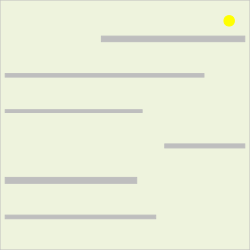

In [27]:
# First we create a 'hard' world to evolve the robot
static_sim = Physics()
make_world(static_sim)
canvas = Canvas((250, 250))
static_sim.draw(canvas)
clear_output(wait=True)
display(canvas)

The config variable generates a configuration from the provided CONFIG file, which includes all the parameters defined and used for the values in neat.DefaultGenome etc. 

In [46]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation, 
                     'neat_config')

In [47]:
# Creates a new population p
p = neat.Population(config)
# Add statistics to pretty print progress
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

x = p.run(first, second) runs the function first for second value times and returns the best genome as x. Population p is also modified.

The NEAT implementation also pretty prints its progress

In [78]:
p.run(avoid_wall_and_fly, 5)
p.run(fitness_over_three, 5)
p.run(binary_light_with_static_net, 10)
p.run(binary_light, 5)
winner = p.run(avoid_wall_and_fly, 5)


 ****** Running generation 40 ****** 

Population's average fitness: 2.42811 stdev: 2.95439
Best fitness: 10.91317 - size: (3, 16) - species 16 - id 5112
Average adjusted fitness: 0.179
Mean genetic distance 3.121, standard deviation 0.928
Population of 148 members in 8 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     9   19    10      1.1    0.096     1
    10   15    23      2.0    0.186     4
    11   11     7      0.7    0.064     6
    12   10     4      0.4    0.035     1
    13    5    31      3.0    0.273     4
    14    4    18      2.2    0.197     0
    15    3    28      3.4    0.314     0
    16    2    27      2.9    0.266     1
Total extinctions: 0
Generation time: 115.984 sec (100.312 average)

 ****** Running generation 41 ****** 



KeyboardInterrupt: 

In [56]:
# Some code to execute right after the previous cell to alert of completion
from IPython.display import Audio
import os
def allDone():
  os.system('say "DONE!"')
allDone()

Creates a winner_net from the best genome

In [57]:
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)

Save, return and delete the copy of the population or a particular genome.

In [83]:
def save_population(prefix, pop):
    pickle.dump(copy.deepcopy(p), open(prefix + '.pkl', 'wb'))
def return_population(prefix):
    loaded = pickle.load(open(prefix + '.pkl', 'rb'))
    return loaded
def delete_population(prefix):
    try:
        os.remove(prefix + '.pkl')
    except FileNotFoundError:
        print('Not found')
save_population('binary', p)
y = return_population('binary') # To return pop

Similar to the code provided, this uses the neat net to move the robot.

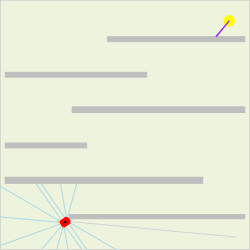

-1.0 -0.6368422219911389


In [79]:
for _ in range(30):
    sim, robot = setup_neat()
    robot.setPose(1, 1, 0)
    canvas = Canvas((250, 250))
    for i in range(500):
        sim.draw(canvas)
        clear_output(wait=True)
        display(canvas)
        inputs = get_brain_inputs(robot)
        x, y = winner_net.activate(inputs)
        print(x, y)
        robot.move(x, y)
        sim.step()
        time.sleep(0.001)
        if robot.stall:
            break